# Exploratory Analysis of ADNI Brain Imaging and Clinical Data
Date: 2025-03-31 06:03:51
Author: KishoreKumarKalli
--------------------------------------------------------------------------------
## Loading Clinical Data Files
ADNI_T1.csv: 99 subjects, 12 variables
CDR.csv: 14110 records, 25 variables
MMSE.csv: 14129 records, 58 variables
GDSCALE.csv: 13203 records, 32 variables
ADAS_ADNI1.csv: 3873 records, 86 variables
NEUROBAT.csv: 16837 records, 83 variables
PTDEMOG.csv: 5857 records, 84 variables
ADAS_ADNIGO23.csv: 7745 records, 124 variables

## 1. Exploring Subject Information

### Overview of Subject Distribution
Group
MCI    42
CN     36
AD     21
Name: count, dtype: int64


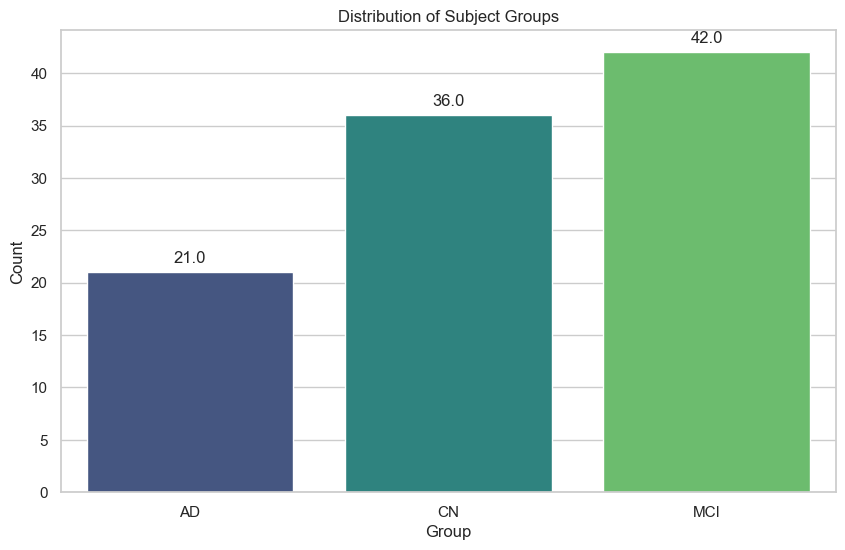

KeyError: 'Subject ID'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting, image
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization parameters
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Display configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

print("# Exploratory Analysis of ADNI Brain Imaging and Clinical Data")
print(f"Date: 2025-03-31 06:03:51")
print(f"Author: KishoreKumarKalli")
print("-" * 80)

# Define data directories
data_dir = '../data'
raw_dir = os.path.join(data_dir, 'raw')
clinical_dir = os.path.join(data_dir, 'clinical')

# Load clinical data files
print("## Loading Clinical Data Files")

# Load subject information
adni_t1 = pd.read_csv(os.path.join(clinical_dir, 'ADNI_T1.csv'))
print(f"ADNI_T1.csv: {adni_t1.shape[0]} subjects, {adni_t1.shape[1]} variables")

# Load clinical assessment data
cdr = pd.read_csv(os.path.join(clinical_dir, 'CDR.csv'))
print(f"CDR.csv: {cdr.shape[0]} records, {cdr.shape[1]} variables")

mmse = pd.read_csv(os.path.join(clinical_dir, 'MMSE.csv'))
print(f"MMSE.csv: {mmse.shape[0]} records, {mmse.shape[1]} variables")

gdscale = pd.read_csv(os.path.join(clinical_dir, 'GDSCALE.csv'))
print(f"GDSCALE.csv: {gdscale.shape[0]} records, {gdscale.shape[1]} variables")

adas_adni1 = pd.read_csv(os.path.join(clinical_dir, 'ADAS_ADNI1.csv'))
print(f"ADAS_ADNI1.csv: {adas_adni1.shape[0]} records, {adas_adni1.shape[1]} variables")

neurobat = pd.read_csv(os.path.join(clinical_dir, 'NEUROBAT.csv'))
print(f"NEUROBAT.csv: {neurobat.shape[0]} records, {neurobat.shape[1]} variables")

ptdemog = pd.read_csv(os.path.join(clinical_dir, 'PTDEMOG.csv'))
print(f"PTDEMOG.csv: {ptdemog.shape[0]} records, {ptdemog.shape[1]} variables")

adas_adnigo23 = pd.read_csv(os.path.join(clinical_dir, 'ADAS_ADNIGO23.csv'))
print(f"ADAS_ADNIGO23.csv: {adas_adnigo23.shape[0]} records, {adas_adnigo23.shape[1]} variables")

print("\n## 1. Exploring Subject Information")

# Display basic information about subjects
print("\n### Overview of Subject Distribution")
subject_counts = adni_t1['Group'].value_counts()
print(subject_counts)

# Visualize group distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Group', data=adni_t1, palette='viridis')
ax.set_title('Distribution of Subject Groups')
ax.set_xlabel('Group')
ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# Merge demographic data with subject information
merged_demo = pd.merge(adni_t1, ptdemog, on='Subject ID', how='left')

print("\n### Demographic Summary by Group")
demo_summary = merged_demo.groupby('Group').agg({
    'Age': ['mean', 'std', 'min', 'max'],
    'Sex': lambda x: (x == 'M').mean() * 100,  # Percentage of males
    'Education': ['mean', 'std']
}).round(2)

# Rename columns for better readability
demo_summary.columns = ['Age (Mean)', 'Age (SD)', 'Age (Min)', 'Age (Max)', '% Male', 'Education (Years, Mean)', 'Education (Years, SD)']
print(demo_summary)

# Visualize age distribution by group
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='Age', data=merged_demo, palette='viridis')
plt.title('Age Distribution by Group')
plt.show()

# Visualize gender distribution by group
plt.figure(figsize=(12, 6))
gender_group = pd.crosstab(merged_demo['Group'], merged_demo['Sex'])
gender_group.plot(kind='bar', stacked=True, color=['#E69F00', '#56B4E9'])
plt.title('Gender Distribution by Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.show()

print("\n## 2. Clinical Assessment Analysis")

# Merge clinical data
merged_clinical = adni_t1[['Subject ID', 'Group']].copy()

# Add MMSE scores
mmse_merged = pd.merge(merged_clinical, mmse, on='Subject ID', how='left')
mmse_summary = mmse_merged.groupby('Group')['MMSE Total'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print("\n### MMSE Score Summary by Group")
print(mmse_summary)

# Add CDR scores
cdr_merged = pd.merge(merged_clinical, cdr, on='Subject ID', how='left')
cdr_summary = cdr_merged.groupby('Group')['Global CDR'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print("\n### CDR Score Summary by Group")
print(cdr_summary)

# Combine MMSE and CDR data for visualization
clinical_viz = merged_clinical.copy()
clinical_viz = pd.merge(clinical_viz, mmse[['Subject ID', 'MMSE Total']], on='Subject ID', how='left')
clinical_viz = pd.merge(clinical_viz, cdr[['Subject ID', 'Global CDR']], on='Subject ID', how='left')

# Plot MMSE by group
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='MMSE Total', data=clinical_viz, palette='viridis')
plt.title('MMSE Scores by Group')
plt.show()

# Plot CDR by group
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='Global CDR', data=clinical_viz, palette='viridis')
plt.title('Clinical Dementia Rating (CDR) by Group')
plt.show()

# Merge GDSCALE
gdscale_merged = pd.merge(merged_clinical, gdscale, on='Subject ID', how='left')
gdscale_summary = gdscale_merged.groupby('Group')['GDTOTAL'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print("\n### Geriatric Depression Scale Summary by Group")
print(gdscale_summary)

# Add GDS to visualization dataset
clinical_viz = pd.merge(clinical_viz, gdscale[['Subject ID', 'GDTOTAL']], on='Subject ID', how='left')

# Combine ADAS-Cog data from different phases
adas_columns = ['Subject ID', 'Total ADAS-Cog Score']
adas_combined = pd.concat([
    adas_adni1[adas_columns],
    adas_adnigo23[adas_columns]
], ignore_index=True)

# Remove duplicates (keeping first occurrence)
adas_combined = adas_combined.drop_duplicates(subset='Subject ID')

# Merge ADAS-Cog scores
adas_merged = pd.merge(merged_clinical, adas_combined, on='Subject ID', how='left')
adas_summary = adas_merged.groupby('Group')['Total ADAS-Cog Score'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print("\n### ADAS-Cog Score Summary by Group")
print(adas_summary)

# Add ADAS-Cog to visualization dataset
clinical_viz = pd.merge(clinical_viz, adas_combined, on='Subject ID', how='left')

# Create correlation heatmap of clinical measures
clinical_corr = clinical_viz.drop(['Subject ID', 'Group'], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(clinical_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Correlation Between Clinical Measures')
plt.show()

# Statistical tests comparing groups
print("\n### Statistical Comparison Between Groups")

def run_group_comparisons(data, variable):
    # Get data for each group
    cn_data = data[data['Group'] == 'CN'][variable].dropna()
    mci_data = data[data['Group'] == 'MCI'][variable].dropna()
    ad_data = data[data['Group'] == 'AD'][variable].dropna()
    
    # Run tests
    # CN vs. MCI
    try:
        cn_mci_t, cn_mci_p = stats.ttest_ind(cn_data, mci_data, equal_var=False)
    except:
        cn_mci_t, cn_mci_p = float('nan'), float('nan')
    
    # CN vs. AD
    try:
        cn_ad_t, cn_ad_p = stats.ttest_ind(cn_data, ad_data, equal_var=False)
    except:
        cn_ad_t, cn_ad_p = float('nan'), float('nan')
    
    # MCI vs. AD
    try:
        mci_ad_t, mci_ad_p = stats.ttest_ind(mci_data, ad_data, equal_var=False)
    except:
        mci_ad_t, mci_ad_p = float('nan'), float('nan')
    
    # Return results
    return pd.DataFrame({
        'Comparison': ['CN vs. MCI', 'CN vs. AD', 'MCI vs. AD'],
        't-statistic': [cn_mci_t, cn_ad_t, mci_ad_t],
        'p-value': [cn_mci_p, cn_ad_p, mci_ad_p]
    })

# Run comparisons for each clinical measure
print("\nMMSE Group Comparisons:")
mmse_stats = run_group_comparisons(clinical_viz, 'MMSE Total')
print(mmse_stats.round(4))

print("\nCDR Group Comparisons:")
cdr_stats = run_group_comparisons(clinical_viz, 'Global CDR')
print(cdr_stats.round(4))

print("\nADAS-Cog Group Comparisons:")
adas_stats = run_group_comparisons(clinical_viz, 'Total ADAS-Cog Score')
print(adas_stats.round(4))

print("\nGDS Group Comparisons:")
gds_stats = run_group_comparisons(clinical_viz, 'GDTOTAL')
print(gds_stats.round(4))

print("\n## 3. Brain Imaging Data Exploration")

# Define directories for each group
cn_dir = os.path.join(raw_dir, 'CN')
mci_dir = os.path.join(raw_dir, 'MCI')
ad_dir = os.path.join(raw_dir, 'AD')

# Count number of files in each directory
cn_files = len([f for f in os.listdir(cn_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
mci_files = len([f for f in os.listdir(mci_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
ad_files = len([f for f in os.listdir(ad_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])

print(f"Number of NIfTI files: CN={cn_files}, MCI={mci_files}, AD={ad_files}")

# Function to load a sample image from each group and extract basic properties
def get_image_properties(group_dir):
    nii_files = [f for f in os.listdir(group_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]
    if not nii_files:
        return None
    
    sample_file = os.path.join(group_dir, nii_files[0])
    img = nib.load(sample_file)
    
    # Extract properties
    properties = {
        'shape': img.shape,
        'data_type': img.get_data_dtype(),
        'affine': img.affine,
        'header': {
            'voxel_size': img.header.get_zooms(),
            'qform_code': img.header['qform_code'],
            'sform_code': img.header['sform_code']
        },
        'filename': nii_files[0]
    }
    
    return properties, img

# Get sample properties from each group
print("\n### MRI Image Properties")
cn_props, cn_img = get_image_properties(cn_dir)
print("\nControl Normal Sample:")
print(f"Filename: {cn_props['filename']}")
print(f"Dimensions: {cn_props['shape']}")
print(f"Data Type: {cn_props['data_type']}")
print(f"Voxel Size (mm): {cn_props['header']['voxel_size']}")

# Function to visualize sample images
def plot_sample_brain_slices(img, title):
    # Get data
    data = img.get_fdata()
    
    # Get middle slices
    x_mid = data.shape[0] // 2
    y_mid = data.shape[1] // 2
    z_mid = data.shape[2] // 2
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Sagittal view (X plane)
    axes[0].imshow(np.rot90(data[x_mid, :, :]), cmap='gray')
    axes[0].set_title('Sagittal')
    axes[0].axis('off')
    
    # Coronal view (Y plane)
    axes[1].imshow(np.rot90(data[:, y_mid, :]), cmap='gray')
    axes[1].set_title('Coronal')
    axes[1].axis('off')
    
    # Axial view (Z plane)
    axes[2].imshow(np.rot90(data[:, :, z_mid]), cmap='gray')
    axes[2].set_title('Axial')
    axes[2].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot sample brains from each group
print("\n### Sample Brain Visualizations")
plot_sample_brain_slices(cn_img, "Control Normal Sample Brain")

# Get a sample from MCI group
mci_props, mci_img = get_image_properties(mci_dir)
plot_sample_brain_slices(mci_img, "Mild Cognitive Impairment Sample Brain")

# Get a sample from AD group
ad_props, ad_img = get_image_properties(ad_dir)
plot_sample_brain_slices(ad_img, "Alzheimer's Disease Sample Brain")

# Calculate and visualize intensity distributions
print("\n### Intensity Distribution Analysis")

def plot_intensity_histogram(img, group_label, color):
    data = img.get_fdata()
    # Filter out zeros (background)
    brain_voxels = data[data > 0]
    
    plt.hist(brain_voxels.flatten(), bins=100, alpha=0.5, color=color, label=group_label, density=True)

plt.figure(figsize=(12, 8))
plot_intensity_histogram(cn_img, "CN", "blue")
plot_intensity_histogram(mci_img, "MCI", "orange")
plot_intensity_histogram(ad_img, "AD", "red")
plt.title("Brain Intensity Distributions by Group")
plt.xlabel("Intensity")
plt.ylabel("Density")
plt.legend()
plt.show()

print("\n## 4. Neuropsychological Test Analysis")

# Analyze neuropsychological battery data
neuro_merged = pd.merge(merged_clinical, neurobat, on='Subject ID', how='left')

# Select relevant cognitive test scores
cog_tests = [
    'AVDEL30MIN', # Auditory Verbal Learning Test - Delayed
    'AVDELTOT',   # Auditory Verbal Learning Test - Total
    'TRAASCOR',   # Trail Making Test A Score
    'TRABSCOR',   # Trail Making Test B Score
    'CATANIMSC',  # Category Fluency (Animals)
    'CATVELSC',   # Category Fluency (Vegetables)
]

# Create summary statistics of cognitive tests by group
neuro_summary = neuro_merged.groupby('Group')[cog_tests].agg(['mean', 'std']).round(2)
print("\n### Neuropsychological Test Results by Group")
print(neuro_summary)

# Create paired plots of cognitive tests
plt.figure(figsize=(15, 15))
sns.pairplot(data=neuro_merged, vars=cog_tests, hue='Group', palette='viridis', 
             plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'})
plt.suptitle('Relationships Between Cognitive Test Scores', y=1.02)
plt.show()

# Compare Trail Making Tests A vs B
plt.figure(figsize=(10, 8))
plt.scatter(neuro_merged[neuro_merged['Group'] == 'CN']['TRAASCOR'], 
            neuro_merged[neuro_merged['Group'] == 'CN']['TRABSCOR'], 
            c='blue', label='CN', alpha=0.7)
plt.scatter(neuro_merged[neuro_merged['Group'] == 'MCI']['TRAASCOR'], 
            neuro_merged[neuro_merged['Group'] == 'MCI']['TRABSCOR'], 
            c='orange', label='MCI', alpha=0.7)
plt.scatter(neuro_merged[neuro_merged['Group'] == 'AD']['TRAASCOR'], 
            neuro_merged[neuro_merged['Group'] == 'AD']['TRABSCOR'], 
            c='red', label='AD', alpha=0.7)
plt.xlabel('Trail Making Test A Score (seconds)')
plt.ylabel('Trail Making Test B Score (seconds)')
plt.title('Trail Making Test A vs B by Diagnostic Group')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n## 5. Data Completeness Analysis")

